# 学校のクラス編成問題

## 1. 問題設定
とある学校のある学年のクラス編成を考える問題を考える。
#### 1-1. 前提条件
 - 学年の人数：318人（男子：158人、女子：160人）
 - クラス数：8
 - 学力試験は500点満点で、学年平均点は303.6点
 - 学年にリーダー気質の生徒が17人いる
 - 学年に特別な支援が必要な生徒が4人いる
#### 1-2. 解くべき最適化問題の要件
 - 318人の生徒全員をそれぞれ1つのクラスに割り当てる
 - 8つのクラスに割り当てるので、各クラスの生徒数は39人以上、40人以下とする
 - クラスの男女の割合をほぼ一定にするため、各クラスの男子、女子生徒の人数はそれぞれ20人以下とする
 - クラス間の学力差をなくすため、各クラスの学力試験の平均点は学年平均点$\pm10$点とする
 - 各クラスにリーダー気質の生徒を2人以上割り当てる
 - 特別な支援が必要な生徒は各クラスに1人以下とする
 - 同姓同名や双子の兄弟など、特定ペアの生徒は同一クラスに割り当てないように配慮する

## 2. 必要ライブラリのインポートとデータ確認

In [1]:
import numpy as np
import pandas as pd

##### 生徒情報の確認

In [2]:
students_df = pd.read_csv("./data/students.csv")
students_df

,student_id,gender,leader_flag,support_flag,score
0,1,0,0,0,335
1,2,1,0,0,379
2,3,0,0,0,350
3,4,0,0,0,301
4,5,1,0,0,317
...,...,...,...,...,...
313,314,0,0,0,244
314,315,1,0,0,309
315,316,0,0,0,239
316,317,1,0,0,356


student_idがユニークな値で、欠損値なくすべての値が使われているかどうかの確認

In [3]:
studnet_id_list = students_df["student_id"].unique()
is_student_id_unique = len(studnet_id_list) == 318
is_student_id_not_loss = set(range(1,319)) == set(studnet_id_list)
print(f"Num of student_id:{len(studnet_id_list)}")
print(f"Is student_id unique?:{is_student_id_unique}")
print(f"Is there number-loss in student_id?:{is_student_id_not_loss}")

Num of student_id:318
Is student_id unique?:True
Is there number-loss in student_id?:True


In [4]:
students_df["score"].describe()

count    318.000000
mean     303.644654
std       65.179995
min       88.000000
25%      261.000000
50%      310.000000
75%      350.000000
max      485.000000
Name: score, dtype: float64

<AxesSubplot:>

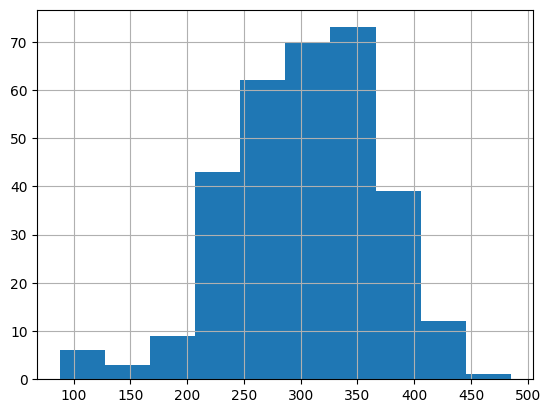

In [5]:
students_df["score"].hist()

In [6]:
students_df["gender"].value_counts()

0    160
1    158
Name: gender, dtype: int64

In [7]:
students_df["leader_flag"].value_counts()

0    301
1     17
Name: leader_flag, dtype: int64

In [8]:
students_df["support_flag"].value_counts()

0    314
1      4
Name: support_flag, dtype: int64

##### 生徒内で考慮が必要な特定ペア情報の確認

In [9]:
students_pair_df = pd.read_csv("./data/student_pairs.csv")
students_pair_df

,student_id1,student_id2
0,118,189
1,72,50
2,314,233


## 3. 最適化問題の定義

In [10]:
import pulp

In [11]:
problem = pulp.LpProblem("ClassAssignmentProblem", pulp.LpMaximize)

#### 3-1. 最適化要件１：318人の生徒全員をそれぞれ1つのクラスに割り当てる
 - 生徒のリスト$S$, クラスのリスト$C$とする。
 - 生徒$s(\in S)$がクラス$c(\in C)$に割り当てられるかどうかを表す変数$x_{s,c}$
   $$
   x_{s,c} = \left\{
   \begin{array}{ll}
   1 & (\text{allocated}) \\ 
   0 & (\text{not allocated})
   \end{array}
   \right.
   $$
 - 各クラスへ割り当てられる
   $$ \sum_{c\in C} x_{s,c} = 1$$


In [12]:
num_of_class = 8
class_list = [c for c in range(num_of_class)]
class_list

[0, 1, 2, 3, 4, 5, 6, 7]

In [13]:
students_list = students_df["student_id"].to_list()
# students_list

In [14]:
# 生徒とクラスの全ペアのリスト
all_class_students_pair = [(s,c) for s in students_list for c in class_list]
# all_class_students_pair

# 生徒をどのクラスに割り当てるかを表す変数を定義
x = pulp.LpVariable.dicts("x",all_class_students_pair, cat="Binary")
# x
# {(1, 0): x_(1,_0),
#  (1, 1): x_(1,_1),
#  (1, 2): x_(1,_2),
#  (1, 3): x_(1,_3),
#  (1, 4): x_(1,_4),...}

In [15]:
# 最適化要件１の実装
for s in students_list:
    problem += pulp.lpSum([x[s,c] for c in class_list]) == 1

#### 3-2. 最適化要件２：各クラスの生徒数は39人以上、40人以下とする
 - 生徒のリスト$S$, クラスのリスト$C$とする
 - 生徒$s(\in S)$がクラス$c(\in C)$に割り当てられるかどうかを表す変数$x_{s,c}$
 - 満たすべき条件式：
    $$ \sum_{s \in S} x_{s,c} >= 39$$
    $$ \sum_{s \in S} x_{s,c} <= 40$$

In [16]:
#最適化要件２の実装
for c in class_list:
    problem += pulp.lpSum([x[s,c] for s in students_list]) >= 39
    problem += pulp.lpSum([x[s,c] for s in students_list]) <= 40

#### 3-3. 最適化要件３：各クラスの男子、女子生徒の人数はそれぞれ20人以下とする
 - 生徒のリスト$S$, クラスのリスト$C$とする
 - 男子生徒のリスト$S_{\text{male}}$, 女子生徒のリスト$S_{\text{female}}$とする。
 - 生徒$s(\in S)$がクラス$c(\in C)$に割り当てられるかどうかを表す変数$x_{s,c}$が満たすべき条件式
   $$ \sum_{s \in S_{\text{male}}} x_{s,c} <= 20$$
   $$ \sum_{s \in S_{\text{female}}} x_{s,c} <= 20$$

In [17]:
male_df = students_df[students_df["gender"] == 1]
male_list = male_df["student_id"].to_list()
print(f"num of male:{len(male_list)}")

num of male:158


In [18]:
female_df = students_df[students_df["gender"] == 0]
female_list = female_df["student_id"].to_list()
print(f"num of female:{len(female_list)}")

num of female:160


In [19]:
#最適化要件３の実装
for c in class_list:
    problem += pulp.lpSum([x[ms,c] for ms in male_list]) <= 20
    problem += pulp.lpSum([x[fs,c] for fs in female_list]) <= 20

#### 3-4. 最適化要件４：各クラスの学力試験の平均点は学年平均点±10点とする
 - 生徒のリスト$S$, クラスのリスト$C$
 - 生徒$s(\in S)$がクラス$c(\in C)$に割り当てられるかどうかを表す変数$x_{s,c}$
 - 生徒$s(\in S)$の学力試験の点数$p_{s}$, 学年の平均点$p_{mean}$
 - 満たすべき条件式
   $$ \frac{\sum_{s \in S} p_{s} x_{s, c}}{\sum_{s \in S} x_{s,c}} >= (p_{mean} - 10) $$
   $$ \frac{\sum_{s \in S} p_{s} x_{s, c}}{\sum_{s \in S} x_{s,c}} <= (p_{mean} + 10) $$

ただし、満たすべき条件式が非線形の式となっており、使える最適化ソルバが限定されると同時に、解くことができるサイズが限定される。そのため、条件式を次のように変形して線形最適化問題に落とし込む。

 - 満たすべき条件式
   $$ \sum_{s \in S} p_{s} x_{s, c} >= (p_{mean} - 10) * \sum_{s \in S} x_{s,c}$$
   $$ \sum_{s \in S} p_{s} x_{s, c} <= (p_{mean} + 10) * \sum_{s \in S} x_{s,c}$$
 

In [20]:
# 最適化要件４の実装
p_mean = students_df["score"].mean()
print(f"Mean scoer of students:{p_mean}")
score_dict = {row.student_id:row.score for row in students_df.itertuples()}
# print(score_list)
for c in class_list:
    problem += pulp.lpSum([score_dict[s] * x[s,c] for s in students_list]) >= (p_mean - 10) * pulp.lpSum([x[s,c] for s in students_list])
    problem += pulp.lpSum([score_dict[s] * x[s,c] for s in students_list]) <= (p_mean + 10) * pulp.lpSum([x[s,c] for s in students_list])

Mean scoer of students:303.6446540880503


#### 3-5. 最適化要件５：各クラスにリーダー気質の生徒を2人以上割り当てる
 - リーダー気質の生徒リスト$S_{\text{leader}}$
 - 生徒$s(\in S)$がクラス$c(\in C)$に割り当てられるかどうかを表す変数$x_{s,c}$
 - 満たすべき条件式
   $$\sum_{s \in S_{\text{leader}}} x_{s,c} >= 2$$

In [21]:
# リーダー気質の生徒のリスト作成
leader_list = [row.student_id for row in students_df.itertuples() if row.leader_flag==1 ]
print(len(leader_list))
leader_list

17


[13, 28, 42, 74, 86, 88, 121, 138, 160, 184, 188, 220, 228, 248, 277, 284, 309]

In [22]:
# 最適化要件５の実装
for c in class_list:
    problem += pulp.lpSum([x[s,c] for s in leader_list]) >= 2

#### 3-6. 最適化要件６：特別な支援が必要な生徒は各クラスに1人以下とする
 - 特別な支援が必要な生徒のリスト$S_{\text{support}}$
 - 生徒$s(\in S)$がクラス$c(\in C)$に割り当てられるかどうかを表す変数$x_{s,c}$
 - 満たすべき条件式
   $$\sum_{s \in S_{\text{support}}} x_{s,c} <= 1$$

In [23]:
support_list = [row.student_id for row in students_df.itertuples() if row.support_flag == 1]
print(len(support_list))
support_list

4


[27, 78, 263, 280]

In [24]:
# 最適化要件６の実装
for c in class_list:
    problem += pulp.lpSum([x[s,c] for s in support_list]) <= 1

#### 3-7. 最適化要件７：特定ペアの生徒は同一クラスに割り当てないように配慮する
 - 特定ペアの生徒リスト$S_{\text{special}}$
 - 生徒$s(\in S)$がクラス$c(\in C)$に割り当てられるかどうかを表す変数$x_{s,c}$
 - 満たすべき条件式
   $$x_{s1,c} + x_{s2, c} <= 1 \ \ ((s1, s2) \in S_{\text{special}})$$

In [25]:
# students_pair_df["student_id1"]
students_pair_tuple_list = [(row.student_id1, row.student_id2) for row in students_pair_df.itertuples()]
students_pair_tuple_list

[(118, 189), (72, 50), (314, 233)]

In [26]:
# 最適化要件７の実装
for s1, s2 in students_pair_tuple_list:
    for c in class_list:
        problem += pulp.lpSum([x[s1,c], x[s2,c]]) <= 1

In [27]:
# print(problem)

#### 3-8. 最適化問題の求解

In [28]:
status = problem.solve()
print(status)
print(pulp.LpStatus[status])

Welcome to the CBC MILP Solver 
Version: 2.9.0 
Build Date: Feb 12 2015 

command line - /home/ren-ito/anaconda3/envs/numerical-optimizaion-env/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/453138ba7fe3407e9a37c763d0d84dad-pulp.mps max branch printingOptions all solution /tmp/453138ba7fe3407e9a37c763d0d84dad-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 411 COLUMNS
At line 20981 RHS
At line 21388 BOUNDS
At line 23934 ENDATA
Problem MODEL has 406 rows, 2545 columns and 15480 elements
Coin0008I MODEL read with 0 errors
Continuous objective value is 0 - 0.09 seconds
Cgl0005I 318 SOS with 2544 members
Cgl0004I processed model has 398 rows, 2544 columns (2544 integer (2544 of which binary)) and 12936 elements
Cbc0038I Initial state - 34 integers unsatisfied sum - 7.56665
Cbc0038I Pass   1: suminf.    0.51447 (8) obj. 0 iterations 369
Cbc0038I Pass   2: suminf.    0.77241 (4) obj. 0 iterations 498
Cbc0038I Solution found of 0
Cb

#### 3-9. 最適化問題の結果の表示

In [29]:
student_class_mapping_dict = {}
for c in class_list:
    student_class_mapping_dict[c] = [s for s in students_list if x[s,c].value() == 1]

for c, s in student_class_mapping_dict.items():
    print(f"Class:{c}")
    print(f"Num:{len(s)}")
    print(f"Students:{s}")
    print("")

Class:0
Num:39
Students:[2, 9, 19, 39, 42, 63, 65, 71, 79, 83, 85, 88, 99, 109, 111, 123, 126, 136, 138, 145, 148, 165, 168, 173, 177, 179, 180, 193, 199, 206, 224, 233, 240, 246, 264, 267, 291, 292, 298]

Class:1
Num:40
Students:[11, 15, 23, 43, 48, 50, 70, 82, 89, 91, 102, 104, 113, 114, 120, 121, 124, 127, 149, 159, 167, 170, 172, 176, 190, 203, 213, 220, 222, 231, 238, 245, 263, 270, 275, 276, 283, 287, 290, 317]

Class:2
Num:39
Students:[3, 10, 14, 25, 27, 31, 33, 41, 49, 53, 54, 58, 73, 93, 97, 98, 107, 122, 152, 156, 160, 171, 187, 210, 211, 217, 219, 227, 236, 242, 254, 258, 260, 268, 273, 277, 278, 301, 318]

Class:3
Num:40
Students:[13, 16, 36, 37, 51, 56, 59, 61, 67, 68, 75, 84, 87, 92, 108, 128, 139, 140, 142, 146, 158, 161, 175, 183, 192, 198, 205, 221, 225, 235, 241, 252, 255, 256, 257, 261, 266, 284, 293, 316]

Class:4
Num:40
Students:[4, 5, 21, 22, 24, 38, 69, 72, 78, 96, 105, 106, 115, 129, 132, 141, 143, 150, 154, 164, 166, 184, 189, 195, 196, 197, 200, 212, 243, 244,

## 4. 最適化問題の結果の検証

#### 4-1. 最適化要件１の検証
 - 「318人の生徒全員をそれぞれ1つのクラスに割り当てる」ことが満たされているか検証

In [36]:
studentid_class_mapping_dict = {s:c for s in students_list for c in class_list if x[s,c].value()==1}
# studentid_class_mapping_dict

In [42]:
result_df = pd.DataFrame.from_dict(studentid_class_mapping_dict.values())
result_df

,0
0,5
1,0
2,2
3,4
4,4
...,...
313,7
314,4
315,3
316,1


In [46]:
result_df.shape

(318, 1)

In [62]:
result_df.isnull().any()

0    False
dtype: bool

In [63]:
result_df.isnull().any().sum()

0

In [43]:
students_result_df = students_df.copy()
students_result_df["class"] =result_df
students_result_df

,student_id,gender,leader_flag,support_flag,score,class
0,1,0,0,0,335,5
1,2,1,0,0,379,0
2,3,0,0,0,350,2
3,4,0,0,0,301,4
4,5,1,0,0,317,4
...,...,...,...,...,...,...
313,314,0,0,0,244,7
314,315,1,0,0,309,4
315,316,0,0,0,239,3
316,317,1,0,0,356,1


このdfが問題なく作られており、class列のdfにNoneがないということは1人に1つのクラスが割り当てられていることの確認ができた、ということを意味している。

#### 4-2. 最適化要件２の検証
 - 「各クラスの生徒数は39人以上、40人以下とする」ことが満たされているか検証

In [68]:
print("Check the number of students in each class...")
for c, s in student_class_mapping_dict.items():
    print(f"class:{c}")
    print(f"Allocated results:{len(s)}")
    if len(s) < 39 or len(s) > 40:
        print(f"Error!!:: class {c} is allocated more or less allocated number of students than expected")
    else:
        print("OK")
    print("")

Check the number of students in each class...
class:0
Allocated results:39
OK

class:1
Allocated results:40
OK

class:2
Allocated results:39
OK

class:3
Allocated results:40
OK

class:4
Allocated results:40
OK

class:5
Allocated results:40
OK

class:6
Allocated results:40
OK

class:7
Allocated results:40
OK



#### 4-3.最適化要件３の検証
 - 「各クラスの男子、女子生徒の人数はそれぞれ20人以下とする」ことが満たされていることの検証

In [77]:
print("Check the number of male and female students in each class...")
for i in range(num_of_class):
    print(f"class:{i}")
    students_result_class_i_df = students_result_df[students_result_df["class"] == i]
    male_students_result_class_i_df = students_result_class_i_df[students_result_class_i_df["gender"] == 1]
    female_students_result_class_i_df = students_result_class_i_df[students_result_class_i_df["gender"] == 0]
    male_number = len(male_students_result_class_i_df)
    female_number = len(female_students_result_class_i_df)
    print(f"number of male:{male_number}")
    print(f"number of female:{female_number}")
    
    if male_number > 20 or female_number > 20:
        print(f"Error!!:: class {i} is allocated more or less number of male or female than expected")
    else:
        print("OK")
        print("")

Check the number of male and female students in each class...
class:0
number of male:19
number of female:20
OK

class:1
number of male:20
number of female:20
OK

class:2
number of male:19
number of female:20
OK

class:3
number of male:20
number of female:20
OK

class:4
number of male:20
number of female:20
OK

class:5
number of male:20
number of female:20
OK

class:6
number of male:20
number of female:20
OK

class:7
number of male:20
number of female:20
OK



#### 4-4. 最適化要件４の検証
 - 「各クラスの学力試験の平均点は学年平均点±10点とする」ことが満たされていることの検証

In [79]:
print("Check the mean of score in each class...")
for i in range(num_of_class):
    print(f"class:{i}")
    students_result_class_i_df = students_result_df[students_result_df["class"] == i]
    mean_i = students_result_class_i_df["score"].mean()
    print(f"men score:{mean_i}")
    if mean_i < p_mean -10 or mean_i > p_mean + 10:
        print(f"Error!!:: mean score of class {i} less or more than expected")
    else:
        print("OK")
    print("")

Check the mean of score in each class...
class:0
men score:309.0
OK

class:1
men score:295.5
OK

class:2
men score:312.05128205128204
OK

class:3
men score:309.625
OK

class:4
men score:297.175
OK

class:5
men score:294.375
OK

class:6
men score:312.825
OK

class:7
men score:298.95
OK



#### 4-5. 最適化要件５の検証
 - 「各クラスにリーダー気質の生徒を2人以上割り当てる」ことが満たされていることの検証

In [88]:
print("Check the number of students of leader_flag in each class...")
for i in range(num_of_class):
    print(f"class:{i}")
    students_result_class_i_df = students_result_df[students_result_df["class"] == i]
    num_of_leader_class_i = students_result_class_i_df["leader_flag"].sum()
    print(f"num_of_leader:{num_of_leader_class_i}")
    if num_of_leader_class_i <2:
        print(f"Error!!:: number of leader candidates in class {i} less or more than expected")
    else:
        print("OK")
    print("")

Check the number of students of leader_flag in each class...
class:0
num_of_leader:3
OK

class:1
num_of_leader:2
OK

class:2
num_of_leader:2
OK

class:3
num_of_leader:2
OK

class:4
num_of_leader:2
OK

class:5
num_of_leader:2
OK

class:6
num_of_leader:2
OK

class:7
num_of_leader:2
OK



#### 4-6.最適化要件６の検証
 - 「特別な支援が必要な生徒は各クラスに1人以下とする」が満たされていることの検証

In [86]:
print("Check the number of students who needs support by someone...")
for i in range(num_of_class):
    print(f"class:{i}")
    students_result_class_i_df = students_result_df[students_result_df["class"] == i]
    num_of_need_support = students_result_class_i_df["support_flag"].sum()
    print(f"num_of_need_support:{num_of_need_support}")
    if num_of_need_support > 1:
        print(f"Error!!:: number of students who needs support by someone in class {i} is more than expected")
    else:
        print("OK")
    print("")

Check the number of students who needs support by someone...
class:0
num_of_need_support:0
OK

class:1
num_of_need_support:1
OK

class:2
num_of_need_support:1
OK

class:3
num_of_need_support:0
OK

class:4
num_of_need_support:1
OK

class:5
num_of_need_support:0
OK

class:6
num_of_need_support:1
OK

class:7
num_of_need_support:0
OK



#### 4-7.最適化要件７の検証
 - 「特定ペアの生徒は同一クラスに割り当てないように配慮する」が満たされていることの検証

In [144]:
print("Check the class of students who are belong in the special pair list...")
for row in students_pair_df.itertuples():
    id1 = row.student_id1
    id2 = row.student_id2
    print(f"id1:{id1}")
    class_id1 = students_result_df.query(f"student_id=={id1}")["class"].values[0]
    # class_id1 = students_result_df.loc[students_result_df['student_id'] == f'{id1}', 'class'].values[0]
    print(f"class_id1:{class_id1}")
    print(f"id2:{id2}")
    class_id2 = students_result_df.query(f"student_id=={id2}")["class"].values[0]
    print(f"class_id2:{class_id2}")
    
    if class_id1 == class_id2:
        print(f"Error!!:: {id1} and {id2} are allocated the same class {class_id1}")
    else:
        print("OK")
    print("")

    

Check the class of students who are belong in the special pair list...
id1:118
class_id1:6
id2:189
class_id2:4
OK

id1:72
class_id1:4
id2:50
class_id2:1
OK

id1:314
class_id1:7
id2:233
class_id2:0
OK

